<a href="https://colab.research.google.com/github/VladimirYugay/ImageSegmentation/blob/master/SemanticImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110851 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [11]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p storage
!google-drive-ocamlfuse storage

In [13]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [14]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

In [0]:
"""Data utility functions."""
import os

import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms

import _pickle as pickle

# pylint: disable=C0326
SEG_LABELS_LIST = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]


def label_img_to_rgb(label_img):
    label_img = np.squeeze(label_img)
    labels = np.unique(label_img)
    label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]

    label_img_rgb = np.array([label_img,
                              label_img,
                              label_img]).transpose(1,2,0)
    for l in label_infos:
        mask = label_img == l['id']
        label_img_rgb[mask] = l['rgb_values']

    return label_img_rgb.astype(np.uint8)


class SegmentationData(data.Dataset):

    def __init__(self, image_paths_file):
        self.root_dir_name = os.path.dirname(image_paths_file)

        with open(image_paths_file) as f:
            self.image_names = f.read().splitlines()

    def __getitem__(self, key):
        if isinstance(key, slice):
            # get the start, stop, and step from the slice
            return [self[ii] for ii in range(*key.indices(len(self)))]
        elif isinstance(key, int):
            # handle negative indices
            if key < 0:
                key += len(self)
            if key < 0 or key >= len(self):
                raise IndexError("The index (%d) is out of range." % key)
            # get the data from direct index
            return self.get_item_from_index(key)
        else:
            raise TypeError("Invalid argument type.")

    def __len__(self):
        return len(self.image_names)

    def get_item_from_index(self, index):
        to_tensor = transforms.ToTensor()
        img_id = self.image_names[index].replace('.bmp', '')

        img = Image.open(os.path.join(self.root_dir_name,
                                      'images',
                                      img_id + '.bmp')).convert('RGB')
        center_crop = transforms.CenterCrop(240)
        img = center_crop(img)
        img = to_tensor(img)

        target = Image.open(os.path.join(self.root_dir_name,
                                         'targets',
                                         img_id + '_GT.bmp'))
        target = center_crop(target)
        target = np.array(target, dtype=np.int64)

        target_labels = target[..., 0]
        for label in SEG_LABELS_LIST:
            mask = np.all(target == label['rgb_values'], axis=2)
            target_labels[mask] = label['id']

        target_labels = torch.from_numpy(target_labels.copy())

        return img, target_labels

In [0]:
import torch
import torch.nn as nn
from torchvision.models import vgg16
from collections import namedtuple

class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        
        model = vgg16(pretrained = True)
        del model.classifier 
        
        layers = []
        for layer in model.features:
            layer.requires_grad = False
            layers.append(layer)
        self.features = layers
        
    def forward(self, x):
        results = []
        capture = {4, 9, 16, 23, 30}
        for i, layer in enumerate(self.features):
            x = layer(x) 
            if i in capture:
                results.append(x)
        return results

In [17]:
from torchvision.models import vgg16

model = vgg16(pretrained = True)
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [0]:
import torch.nn as nn

class SegmentationNN(nn.Module):

    def __init__(self, num_classes = 23):
        super().__init__()
        
        from torchvision import models
        self.features = models.alexnet(pretrained = True).features
        self.classifier = nn.Sequential(
          nn.Dropout(),
          nn.Conv2d(256, 4096, kernel_size=1, padding=0),
          nn.ReLU(inplace=True),
          nn.Dropout(),
          nn.Conv2d(4096, 4096, kernel_size=1, padding=0),
          nn.ReLU(inplace=True),
          nn.Conv2d(4096, num_classes, kernel_size=1, padding=0),
          nn.Upsample(scale_factor=40),
          nn.Conv2d(num_classes, num_classes, kernel_size=3, padding=1)
        )
        

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
        

In [0]:
from random import shuffle
import numpy as np

import torch
from torch.autograd import Variable


class Solver(object):
    default_adam_args = {"lr": 1e-4, "betas": (0.9, 0.999), "eps": 1e-8, "weight_decay": 0.0}

    def __init__(self, optim=torch.optim.Adam, optim_args={}, loss_func=torch.nn.CrossEntropyLoss()):
        optim_args_merged = self.default_adam_args.copy()
        optim_args_merged.update(optim_args)
        self.optim_args = optim_args_merged
        self.optim = optim
        self.loss_func = loss_func
        self._reset_histories()

    def _reset_histories(self):
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.val_loss_history = []

    def train(self, model, train_loader, val_loader, num_epochs=10, log_nth=0):

        optim = self.optim(model.parameters(), **self.optim_args)
        self._reset_histories()
        iter_per_epoch = len(train_loader)
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        model.to(device)
     
        print("Start Training")  
      
        for epoch in range(num_epochs):
          
          print("Epoch number: ", epoch)     
          
          for i, (inputs, targets) in enumerate(train_loader, 1):
         
            optim.zero_grad()
            
            inputs, targets = inputs.to(device), targets.to(device) 
            outputs = model(inputs)
            loss = self.loss_func(outputs, targets)
            loss.backward()
            optim.step()
            
            self.train_loss_history.append(loss.cpu().detach().numpy())
            if log_nth and i % log_nth == 0:
              last_log_nth_losses = self.train_loss_history[-log_nth:]
              train_loss = np.mean(last_log_nth_losses)
              print('[Iteration] ', i + epoch * iter_per_epoch, " ", iter_per_epoch * num_epochs, "TRAIN loss: ", train_loss)
              
          _, preds = torch.max(outputs, 1)

          target_mask = targets >= 0
          train_acc = np.mean((preds == targets)[target_mask].cpu().detach().numpy())
          self.train_acc_history.append(train_acc)

          if log_nth:
            print('[Epoch %d/%d] TRAIN acc/loss: %.3f/%.3f' % (epoch + 1, num_epochs, train_acc, train_loss))

          #VALIDATION 
          val_losses = []
          val_scores = []
          model.eval()
          for inputs, targets in val_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model.forward(inputs)
            loss = self.loss_func(outputs, targets)
            val_losses.append(loss.detach().cpu().numpy())

            _, preds = torch.max(outputs, 1)

            target_mask = targets >= 0
            scores = np.mean((preds == targets)[target_mask].cpu().detach().numpy())
            val_scores.append(scores)

          model.train()
          val_acc, val_loss = np.mean(val_scores), np.mean(val_losses)
          self.val_acc_history.append(val_acc)
          self.val_loss_history.append(val_loss)

          if log_nth:
            print('[Epoch %d/%d] VAL acc/loss: %.3f/%.3f' % (epoch + 1, num_epochs, val_acc, val_loss))

        print('FINISH.')

In [0]:
import os
from torchvision import datasets

path = "storage/Datasets/segmentation/segmentation_data/"
datadir = os.path.join(path)

train_data = SegmentationData(image_paths_file="storage/Datasets/segmentation/segmentation_data/train.txt")
val_data = SegmentationData(image_paths_file="storage/Datasets/segmentation/segmentation_data/train.txt")

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 10, shuffle=True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 1, shuffle=False, num_workers = 2)

In [32]:
model = SegmentationNN()

solver = Solver(optim_args={"lr": 2 * 1e-4, "weight_decay": 0.001},
                loss_func=torch.nn.CrossEntropyLoss(size_average=True, ignore_index=-1))
solver.train(model, train_loader, val_loader, log_nth=10, num_epochs=20)

Start Training
Epoch number:  0
[Iteration]  10   560 TRAIN loss:  2.8378146
[Iteration]  20   560 TRAIN loss:  2.4995186
[Epoch 1/20] TRAIN acc/loss: 0.289/2.500
[Epoch 1/20] VAL acc/loss: 0.325/2.224
Epoch number:  1
[Iteration]  38   560 TRAIN loss:  2.0911105
[Iteration]  48   560 TRAIN loss:  1.9145114
[Epoch 2/20] TRAIN acc/loss: 0.605/1.915
[Epoch 2/20] VAL acc/loss: 0.540/1.618
Epoch number:  2
[Iteration]  66   560 TRAIN loss:  1.6312408
[Iteration]  76   560 TRAIN loss:  1.3924925
[Epoch 3/20] TRAIN acc/loss: 0.709/1.392
[Epoch 3/20] VAL acc/loss: 0.657/1.212
Epoch number:  3
[Iteration]  94   560 TRAIN loss:  1.1481303
[Iteration]  104   560 TRAIN loss:  1.1160519
[Epoch 4/20] TRAIN acc/loss: 0.681/1.116
[Epoch 4/20] VAL acc/loss: 0.759/0.823
Epoch number:  4
[Iteration]  122   560 TRAIN loss:  0.9799565
[Iteration]  132   560 TRAIN loss:  0.79065806
[Epoch 5/20] TRAIN acc/loss: 0.606/0.791
[Epoch 5/20] VAL acc/loss: 0.814/0.617
Epoch number:  5
[Iteration]  150   560 TRAIN 

In [33]:
test_data = SegmentationData(image_paths_file="storage/Datasets/segmentation/segmentation_data/train.txt")
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_scores = []
model.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    targets_mask = targets >= 0
    test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model.train()
np.mean(test_scores)

0.9314448733380429

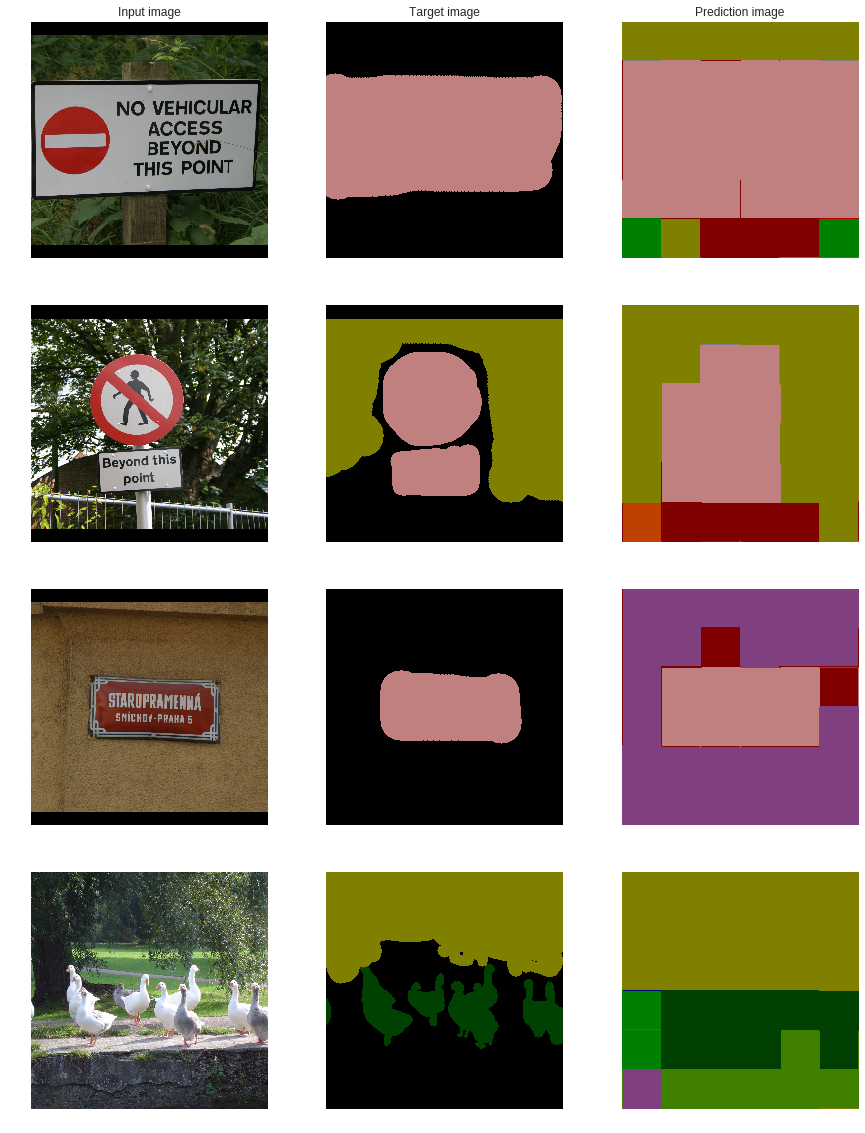

In [36]:
import matplotlib.pyplot as plt

num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = inputs.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

In [0]:
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid


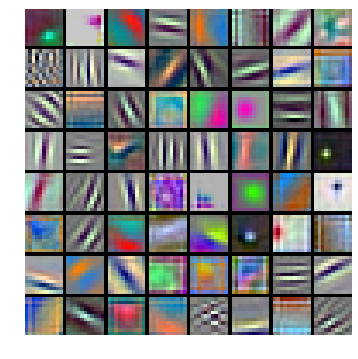

In [38]:
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()